<a href="https://colab.research.google.com/github/eatimofeeva/for_HW/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold,train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import SCORERS,roc_curve, auc,classification_report, r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, LassoCV,Ridge,RidgeCV,ElasticNet, LinearRegression,LogisticRegression
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from time import time


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterinatimofeeva","key":"6b34d38ad8362a6f641921bade0e1c64"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 48.3MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 63.6MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 483kB/s]
 99% 1.54G/1.56G [00:13<00:00, 154MB/s]
100% 1.56G/1.56G [00:13<00:00, 121MB/s]


In [8]:
!ls

GCP-Coupons-Instructions.rtf  sample_data	     test.csv
kaggle.json		      sample_submission.csv  train.csv.zip


In [9]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [5]:
import dask.dataframe as dd
df = dd.read_csv('train.csv')

In [11]:
chunksize = 10 ** 6
batch_no=1
for chunk in pd.read_csv('train.csv', chunksize=chunksize):
    chunk.to_csv('chunk'+str(batch_no)+'.csv',index=False)
    batch_no+=1

In [12]:
df1 = pd.read_csv('chunk1.csv')

In [16]:
from google.colab import files
files.download("chunk1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
df1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


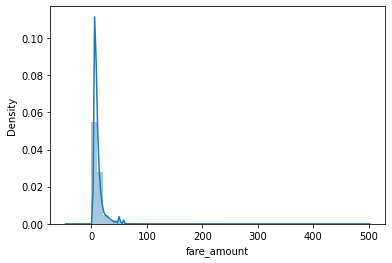

In [18]:
sns.distplot(df1['fare_amount'], kde=True)

In [19]:
df1['distance'] = sqrt((df1['dropoff_longitude']-df1['pickup_longitude'])**2+(df1['dropoff_latitude']-df1['pickup_latitude'])**2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


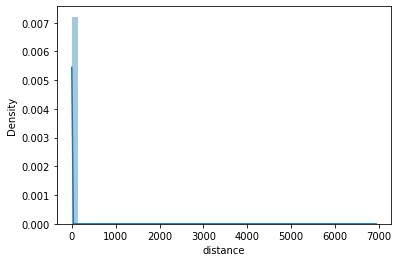

In [20]:
sns.distplot(df1['distance'], kde=True)

In [21]:
len(df1)

1000000

In [23]:
df1.dropna(subset=['distance'])

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470
...,...,...,...,...,...,...,...,...,...
999995,2014-09-13 21:44:38.0000001,7.0,2014-09-13 21:44:38 UTC,-73.976676,40.785630,-73.959196,40.775114,1,0.020399
999996,2010-09-20 14:50:37.0000002,7.3,2010-09-20 14:50:37 UTC,-73.992103,40.671385,-73.992103,40.671385,2,0.000000
999997,2013-04-26 14:03:00.000000118,10.5,2013-04-26 14:03:00 UTC,-73.978423,40.751135,-73.993397,40.762197,5,0.018617
999998,2011-07-08 00:29:00.00000099,6.9,2011-07-08 00:29:00 UTC,-73.980317,40.759482,-73.976832,40.743122,1,0.016727


In [25]:
len(df1)

1000000

In [26]:
y = df1['fare_amount']
x = df1[['distance','passenger_count']]

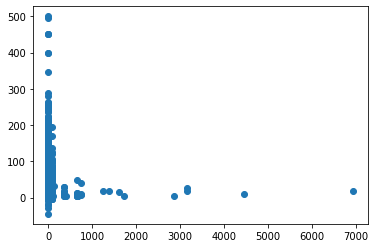

In [30]:
plt.scatter(df1['distance'],df1['fare_amount'])

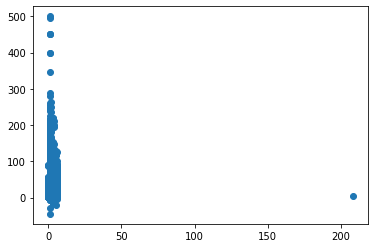

In [33]:
plt.scatter(df1['passenger_count'],df1['fare_amount'])

In [36]:
df1[df1['passenger_count']>200]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
929022,2009-07-30 11:54:00.000000193,3.3,2009-07-30 11:54:00 UTC,0.0,0.0,0.0,0.0,208,0.0


In [38]:
df1 = df1[df1['passenger_count']<200]
len(df1)

999999

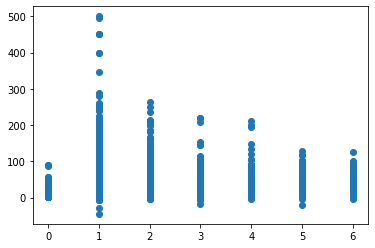

In [39]:
plt.scatter(df1['passenger_count'],df1['fare_amount'])

In [40]:
df1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,999999.000000,999999.000000,999999.000000,999989.000000,999989.000000,999999.000000,999989.000000
mean,11.348087,-72.526712,39.929048,-72.527932,39.919994,1.684718,0.231611
std,9.822092,12.057725,7.626053,11.324268,8.201325,1.307737,11.284490
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734047,1.000000,0.012400
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,0.021443
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,0.038403
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,6.000000,6933.843499


In [41]:
Xtrain

,distance,passenger_count
785721,0.099034,1
757027,0.012337,1
525150,0.030786,3
410633,0.028601,1
89573,0.055439,1
...,...,...
359252,0.029519,3
636464,0.031325,1
509121,0.018742,1
199881,0.017561,1


In [43]:
ytrain

785721    25.30
757027     6.10
525150    12.00
410633    16.00
89573     22.00
          ...  
359252     9.30
636464     7.30
509121     9.00
199881     5.50
814120    37.33
Name: fare_amount, Length: 800000, dtype: float64

In [27]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((800000, 2), (200000, 2), (800000,), (200000,))